In [1]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

In [2]:
const qx = [1/6, 2/3, 1/6]
const qy = [2/3, 1/6, 1/6]
const wg = [1/6, 1/6, 1/6]

function basis() # for integration points
    x1, x2, x3 = qx[1], qx[2], qx[3]
    y1, y2, y3 = qy[1], qy[2], qy[3]
    ϕ = zeros(3, 2, 3)
    ϕ[:,:,1] .= [ x1    y1;          x2   y2;          x3   y3]
    ϕ[:,:,2] .= [ x1   (y1 - 1.0);   x2  (y2 - 1.0);   x3  (y3 - 1.0)]
    ϕ[:,:,3] .= [(x1 - 1.0)    y1;  (x2 - 1.0)   y2;  (x3 - 1.0)   y3]
    return ϕ
end

function TandD(x1, y1, x2, y2, x3, y3)
    J = [(x2 - x1) (x3 - x1); (y2 - y1) (y3 - y1)]
    ϕ = basis()
    T = spzeros(3, 3)
    D = ones(1, 3)
    
    for i=1:3
        for j=1:3
            for k=1:3
                T[i, j] += wg[k] / abs(det(J)) * dot(J * ϕ[k,:,i], J * ϕ[k,:,j])
            end
        end
        D[i] = sign(det(J))
    end

    return T, D
end

TandD (generic function with 1 method)

In [3]:
ε0 = 1.0 #8.854e-12
μ0 = 1.0 #4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

n̂  = x̂ = [1.0, 0.0]
# Meshing
a = 1.0 # m
b = 1.0 # m
nothing

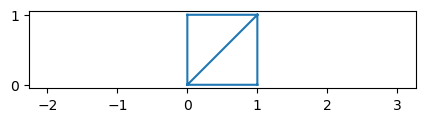

In [4]:
using PyPlot

# +-+
# +/+
# +-+

LOCALEDGENODES = [2 3; 1 2; 3 1]
NUM_ELEMS = 2
ELEMENTS = [1 2 4; 1 3 4]
NUM_NODES = 4
NODE_COORD = [0.0 0.0; 1.0 0.0; 0.0 1.0; 1.0 1.0]
#trimesh(a, b, 55, 55)
triedgemake()

figure(figsize=(5,1))
triplot(NODE_COORD[:,1], NODE_COORD[:,2], triangles=(ELEMENTS .- 1)); # subtract 1 as we go into Python-world
axis("equal");

In [5]:
DOF_NONE = 0
DOF_PEC  = 1
function dof_type(a, b)
    global NUM_EDGES
    global EDGES
    global NODE_COORD
    dof_flag = zeros(Int64, NUM_EDGES)
    
    for i_edge = 1:NUM_EDGES
       node1 = EDGES[i_edge, 1]
       node2 = EDGES[i_edge, 2]
       if NODE_COORD[node1, 2] ≈ 0. && NODE_COORD[node2, 2] ≈ 0.
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 2] ≈ b  && NODE_COORD[node2, 2] ≈ b
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 1] ≈ 0. && NODE_COORD[node2, 1] ≈ 0.
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 1] ≈ a  && NODE_COORD[node2, 1] ≈ a
           dof_flag[i_edge] = DOF_PEC
       end
    end
    return dof_flag
end

dof_type (generic function with 1 method)

In [6]:
dof = collect(1:NUM_EDGES+NUM_ELEMS)
Γ = dof_type(a, b);
NUM_DOFS = NUM_EDGES;

In [7]:
using SparseArrays

T = spzeros(NUM_DOFS, NUM_DOFS) # 1/ε ∫( ∇Ni ⋅ ∇Nj )dΩ
D = spzeros(NUM_DOFS, NUM_ELEMS) #    ∫((∇⋅Ni) ⋅ Nk )dΩ

for ielem = 1:NUM_ELEMS # Assemble by elements
  trinodes = ELEMENTS[ielem, :]
  Te, De = TandD(NODE_COORD[trinodes[1],1], NODE_COORD[trinodes[1],2],
                 NODE_COORD[trinodes[2],1], NODE_COORD[trinodes[2],2],
                 NODE_COORD[trinodes[3],1], NODE_COORD[trinodes[3],2])
  droptol!(Te, 1e-15)
  
  for jedge = 1:3
    j1 = ELEMENTS[ielem, LOCALEDGENODES[jedge,1]] 
    j2 = ELEMENTS[ielem, LOCALEDGENODES[jedge,2]]
    je = NODE_EDGES[j1, j2]
    jd = sign(je)
    jj = dof[abs(je)]
    for kedge = 1:3
      k1 = ELEMENTS[ielem, LOCALEDGENODES[kedge,1]]
      k2 = ELEMENTS[ielem, LOCALEDGENODES[kedge,2]]
      ke = NODE_EDGES[k1, k2]
      kd = sign(ke)
      kk = dof[abs(ke)]
      T[jj, kk] = T[jj, kk] + jd * kd * Te[jedge, kedge]
    end
    D[jj, ielem] = D[jj, ielem] + jd * De[jedge]
  end
end

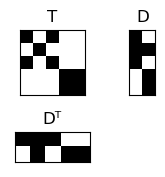

In [8]:
figure(figsize=(2, 2))
subplot(2, 2, 1); spy(T);  title("T"); xticks([]); yticks([]);
subplot(2, 2, 2); spy(D);  title("D"); xticks([]); yticks([]);
subplot(2, 2, 3); spy(D'); title("Dᵀ"); xticks([]); yticks([]);
tight_layout()

In [9]:
Z = spzeros(NUM_ELEMS, NUM_ELEMS)
droptol!(T, 1e-15)
A = [T  D
     D' Z]

7×7 SparseMatrixCSC{Float64, Int64} with 21 stored entries:
  0.333333    ⋅        -0.166667    ⋅          ⋅         1.0    ⋅ 
   ⋅         0.333333    ⋅          ⋅          ⋅        -1.0   1.0
 -0.166667    ⋅         0.333333    ⋅          ⋅         1.0    ⋅ 
   ⋅          ⋅          ⋅         0.333333  -0.166667    ⋅   -1.0
   ⋅          ⋅          ⋅        -0.166667   0.333333    ⋅   -1.0
  1.0       -1.0        1.0         ⋅          ⋅          ⋅     ⋅ 
   ⋅         1.0         ⋅        -1.0       -1.0         ⋅     ⋅ 

In [10]:
# from darcy.py
sparse([
    0.3333         0    0.0000   -0.1667         0    1.0000         0
         0    0.3333   -0.0000         0   -0.1667         0    1.0000
    0.0000   -0.0000    0.3333   -0.0000    0.0000    1.0000   -1.0000
   -0.1667         0   -0.0000    0.3333         0    1.0000         0
         0   -0.1667    0.0000         0    0.3333         0    1.0000
    1.0000         0    1.0000    1.0000         0         0         0
         0    1.0000   -1.0000         0    1.0000         0         0])# \
#[0., 0., 0., 0., 0., 4.9348022, 4.9348022]

7×7 SparseMatrixCSC{Float64, Int64} with 21 stored entries:
  0.3333    ⋅        ⋅      -0.1667    ⋅      1.0    ⋅ 
   ⋅       0.3333    ⋅        ⋅      -0.1667   ⋅    1.0
   ⋅        ⋅       0.3333    ⋅        ⋅      1.0  -1.0
 -0.1667    ⋅        ⋅       0.3333    ⋅      1.0    ⋅ 
   ⋅      -0.1667    ⋅        ⋅       0.3333   ⋅    1.0
  1.0       ⋅       1.0      1.0       ⋅       ⋅     ⋅ 
   ⋅       1.0     -1.0       ⋅       1.0      ⋅     ⋅ 

In [11]:
function f(x, y) sin(2π * x) * sin(2π * y) end
function volumeforce(x1, y1, x2, y2, x3, y3)
    area = abs(det([1. x1 y1
                    1. x2 y2
                    1. x3 y3]))
    xc = (x1 + x2 + x3) / 3.0
    yc = (y1 + y2 + y3) / 3.0
    
    return - 0.5 * 8.0 * π^2 * area *f(xc, yc)
end

volumeforce (generic function with 1 method)

In [12]:
rhs = zeros(NUM_EDGES + NUM_ELEMS)
for ielem=1:NUM_ELEMS
    trinodes = ELEMENTS[ielem, :]
    dof = NUM_EDGES + ielem 
    rhs[dof] = volumeforce(NODE_COORD[trinodes[1],1], NODE_COORD[trinodes[1],2],
                           NODE_COORD[trinodes[2],1], NODE_COORD[trinodes[2],2],
                           NODE_COORD[trinodes[3],1], NODE_COORD[trinodes[3],2])
end

u = A \ rhs
E = view(u, 1:NUM_EDGES)
V = view(u, NUM_EDGES+1:NUM_EDGES+NUM_ELEMS)
nothing
u

7-element Vector{Float64}:
  14.80440660163403
   8.881784197001252e-16
  14.804406601634033
 -14.804406601634039
 -14.804406601634033
  -2.467401100272338
  -2.4674011002723386

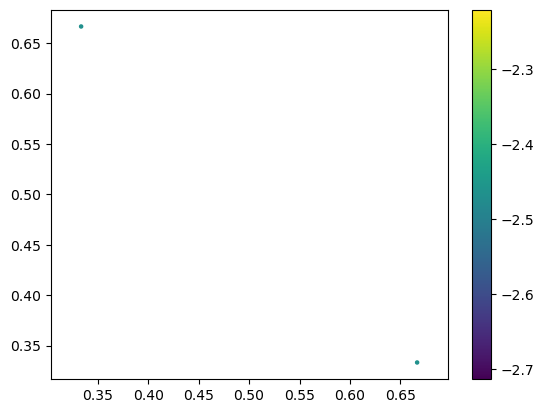

(-2.4674011002723386, -2.467401100272338)

In [13]:
solution = zeros(NUM_ELEMS, 3)
for ielem=1:NUM_ELEMS
    trinodes = ELEMENTS[ielem, :]
    xc = (NODE_COORD[trinodes[1],1] +
          NODE_COORD[trinodes[2],1] +
          NODE_COORD[trinodes[3],1]) / 3.0
    yc = (NODE_COORD[trinodes[1],2] +
          NODE_COORD[trinodes[2],2] +
          NODE_COORD[trinodes[3],2]) / 3.0
    solution[ielem, 1] = xc
    solution[ielem, 2] = yc
    solution[ielem, 3] = u[NUM_EDGES + ielem]
end

scatter(solution[:, 1], solution[:, 2], c=solution[:, 3], s=5.0)
axis("equal")
colorbar()
extrema(solution[:,3])

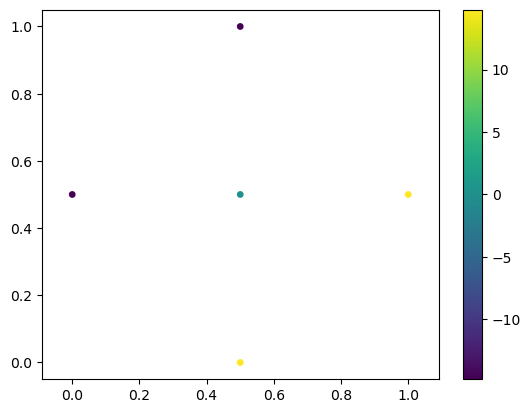

(-14.804406601634039, 14.804406601634033)

In [14]:
solution = zeros(NUM_EDGES, 3)
for iedge=1:NUM_EDGES
    xc = (NODE_COORD[EDGES[iedge,1],1] +
          NODE_COORD[EDGES[iedge,2],1]) / 2.0
    yc = (NODE_COORD[EDGES[iedge,1],2] +
          NODE_COORD[EDGES[iedge,2],2]) / 2.0
    solution[iedge, 1] = xc
    solution[iedge, 2] = yc
    solution[iedge, 3] = u[iedge]
end

scatter(solution[:, 1], solution[:, 2], c=solution[:, 3], s=15.0)
axis("equal")
colorbar()
extrema(solution[:,3])